# NEP tutorial
## 1. Introduction
- In this tutorial, we will show how to use the `nep` executable to train a NEP potential and check the results.
- The NEP potential has been first introduced in **GPUMD-v2.6** and this version wil be called **NEP1**. It corresponds to the following paper: 
  - Zheyong Fan, Zezhu Zeng, Cunzhi Zhang, Yanzhou Wang, Keke Song, Haikuan Dong, Yue Chen, and Tapio Ala-Nissila, Neuroevolution machine learning potentials: Combining high accuracy and low cost in atomistic simulations and application to heat transport, Phys. Rev. B **104**, 104309 (2021). https://doi.org/10.1103/PhysRevB.104.104309
- From **GPUMD-v2.7** to **GPUMD-v2.9** we have updated the NEP potential to **NEP2**, which corresponds to the following paper:
  - Zheyong Fan, Improving the accuracy of the neuroevolution machine learning potential for multi-component systems, arXiv:2109.10643. https://arxiv.org/abs/2109.10643 (accepted to JPCM)
- Now we are using the **GPUMD-master**, and the NEP potential is essentially still **NEP2**, but there are some improvements.  

## 2. Prerequisites
- You need to have access to an Nvidia GPU with compute capability >= 3.5. CUDA 9.0 or higher is also needed to compile the GPUMD package.
- You can download **GPUMD-master**, unpack it, go to the `src` directory, and type `make -j` to compile. Then, you should get two executables: `gpumd` and `nep` in the `src` directory.

## 3. Train a NEP potential for PbTe
- To train a NEP potential, one must prepare three input files: `train.in`, `test.in` and `nep.in`. The `train.in` file contains all the training data, the `test.in` file contains all the testing data, and the `nep.in` file contains some controlling parameters.

### 3.1. Prepare the train.in and test.in files
- The `train.in` file should be prepared according to the documentation: https://gpumd.zheyongfan.org/index.php/The_train.in_input_file
- For the example in this tutorial, we have already prepared the `trian.in` file in the current folder.
- This is the training data set for PbTe as used in the NEP1 paper: https://doi.org/10.1103/PhysRevB.104.104309
- It is also the training data set for PbTe as used in the NEP2 paper: https://arxiv.org/abs/2109.10643
- In this example, there are only energy and force training data. In general, one can also have virial in `train.in`.
- We used the VASP code to calculate the training data, but `nep` does not care about this. You can generate the data in `train.in` using any method that works for you. For example, before doing new DFT calculations, you can first check if there are training data publicly available and then try to convert them into the format as required by `train.in`. There are quite a few tools (https://github.com/brucefan1983/GPUMD/tree/master/tools/nep_related) available for this purpose.
- For simplicity, the `test.in` file has the same data as in the `train.in` file.

### 3.2. Prepare the `nep.in` file. 
- First, study the document about this input file: https://gpumd.zheyongfan.org/index.php/The_nep.in_input_file
- For the example in this tutorial, we have prepared the `nep.in` file in the current folder. 
- The `nep.in` file reads:
```
type         2 Te Pb
cutoff       8 4
n_max        12 6
neuron       40
batch        25
generation   10000
```
- We explain it line by line below:
  - There are $N_{\rm typ}=2$ atoms types in the training set: Te and Pb. The user can also write Pb first and Te next. The code will remember the order of the atom types here and record it into the NEP potential file `nep.txt`. Therefore, the user does not need to remember the order of the atom types here.
  - The radial and angular cutoff distances are $r_{\rm c}^{\rm R}=8$ angstrom and $r_{\rm c}^{\rm A}=4$ angstrom, respectively.
  - The $n_{\rm max}$ parameter for the radial and angular descriptor parts are $n_{\rm max}^{\rm R}=12$ and $n_{\rm max}^{\rm A}=6$, respectively.
  - The number of neurons in the hidden layer (there is only one hidden layer in NEP) is $N_{\rm neu}=40$.
  - The batch size is $N_{\rm bat}=25$.
  - The maximum number of generations is $N_{\rm gen}=10^4$.
  - All the other parameters will have default values (please check the screen output)
 

### 3.3. Run the `nep` executable
 - We have prepared a driver input file `input_nep.txt` in the `examples/nep_potentials` folder. This driver input file reads:
 ```
1
examples/nep_potentials/PbTe/train
```

- Now one can run the `nep` executable to train a NEP potential for PbTe. To do this, first go the directory where you can see `src`. 
  - In Linux, type this to run:
```
src/nep < examples/nep_potentials/input_nep.txt
```
  - In Windows, type this to run:
```
src\nep < examples/nep_potentials/input_nep.txt
```
 
 - This example takes about **12 min** to run using my **laptop** with a GeForce RTX 2070 GPU card.

## 4. Check the training results

- After running the `nep` executable, there will be some output on the screen. We encourage the user to read the screen output carefully. It can help to understand the calculation flow of `nep`. 
- Some files will be generated in the folder containing the `train.in` and `nep.in` files and will be updated every 100 generations (some will be updated every 1000 generations). Therefore, one can check the results even before finishing the maximum number of generations as set in `nep.in`. 
- If the user has not studied the documentation of the output files generated by `nep`, it is time to read it here: https://gpumd.zheyongfan.org/index.php/The_output_files_for_the_nep_executable
- We will use Python to visualize the results in some of the output files next. We first load `pylab` that we need.

In [1]:
from pylab import *

#### 4.1. Checking the `loss.out` file. 
- We see that the $\mathcal{L}_1$ and $\mathcal{L}_2$ regularization loss functions first increase and then decreases, which indicates the effectiveness of the regularization.
- The energy loss is the root mean square error (RMSE) of energy per atom, which converges to about 0.4 meV/atom. 
- The force loss is the RMSE of force components, which converges to about 38 meV/Angstrom. 

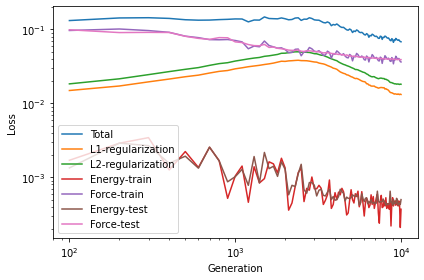

In [2]:
loss = loadtxt('loss.out')
loglog(loss[:, 0], loss[:, 1:6])
loglog(loss[:, 0], loss[:, 7:9])
xlabel('Generation')
ylabel('Loss')
legend(['Total', 'L1-regularization', 'L2-regularization', 'Energy-train', 'Force-train', 'Energy-test', 'Force-test'])
tight_layout()

### 4.2. Checking the `energy_test.out` file

- The dots are the raw data and the line represents the identity function used to guide the eyes.

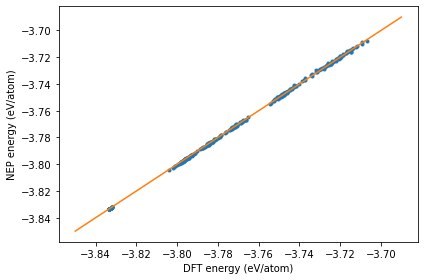

In [3]:
energy_test = loadtxt('energy_test.out')
plot(energy_test[:, 1], energy_test[:, 0], '.')
plot(linspace(-3.85,-3.69), linspace(-3.85,-3.69), '-')
xlabel('DFT energy (eV/atom)')
ylabel('NEP energy (eV/atom)')
tight_layout()

### 4.3. Checking the `force_test.out` file

- The dots are the raw data and the line represents the identity function used to guide the eyes.

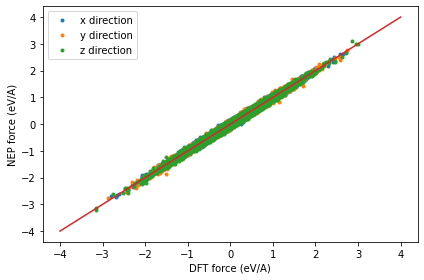

In [4]:
force_test = loadtxt('force_test.out')
plot(force_test[:, 3:6], force_test[:, 0:3], '.')
plot(linspace(-4,4), linspace(-4,4), '-')
xlabel('DFT force (eV/A)')
ylabel('NEP force (eV/A)')
legend(['x direction', 'y direction', 'z direction'])
tight_layout()

### 4.4. Checking the `virial_test.out` file
- In general, one can similarly check the `virial.out` file, but in this particular example, virial data were not used in the training process (no virial data exist in `train.in`). 
- However, `virial.out` still contains the predicted virial data for each structure in the training set.

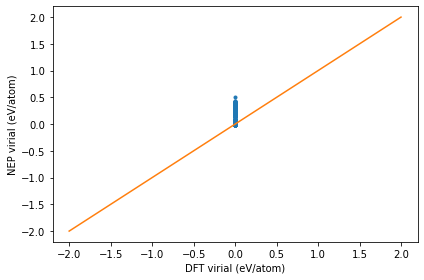

In [5]:
virial_test = loadtxt('virial_test.out')
plot(virial_test[:, 1], virial_test[:, 0], '.')
plot(linspace(-2,2), linspace(-2,2), '-')
xlabel('DFT virial (eV/atom)')
ylabel('NEP virial (eV/atom)')
tight_layout()

### 4.5. Checking the other files
- One can similarly check the other files: `energy_train.out`, `force_train.out`, and `virial_train.out`. In this example, we have used the same data for training and testing. 

## 5. Restart
- After each 100 steps, the `nep.restart` file will be updated.
- If `nep.restart` exists, it means you want to continue the previous training. Remember not to change the parameters related to the descriptor and the number of neurons. Otherwise the restarting behavior is undefined.
- If you want to train from scratch, you need to delete `nep.restart` first (better to first make a copy of all the results from the previous training).